## Brazilian E-Commerce Public Dataset by Olist
https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce/data

**分析目標**
 
- 目標客群（Who）：已經完成首購的客戶，預測「誰會再次購買」。

- 目標行為（What）：預測哪些客戶會在一定時間內回購（例如 30 天、60 天內）。

- 商業價值（Why）：針對高機率回購客戶進行廣告再行銷，提升轉換率並降低廣告浪費，提高ROAS。

**分析問題**

- 哪些客戶有最高機率再次購買？

- 哪些付款方式、地區或商品類別的客戶忠誠度較高？

- 如何透過精準投放廣告，提高再購轉換率並降低 CPA？

##### **1. 資料整理**

| 表格名稱             | 主要內容   | 用途                |
| ---------------- | ------ | ----------------- |
| `orders`     | 訂單資料   | 計算首次購買、再購行為標記 |
| `customers` | 客戶基本資料   |  分析地區、客戶類型等特徵   |
| `order_items`  | 商品明細 | 計算消費金額、商品類別      |
| `order_payments` | 付款資料   | 付款方式分析       |


In [1]:
# !pip install pandas

In [2]:
import pandas as pd

# 載入 Olist 主要資料表
orders = pd.read_csv('olist_orders_dataset.csv')
customers = pd.read_csv('olist_customers_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')
payments = pd.read_csv('olist_order_payments_dataset.csv')

建立目標變數 - 是否再次購買

- 連接 `customer_id` 與 `customer_unique_id`

In [3]:
customer_lookup = customers[['customer_id', 'customer_unique_id']]
orders = orders.merge(customer_lookup, on='customer_id', how='left')

In [4]:
# merge() 是一個函數，用來將兩個 DataFrame 進行合併
# on 是一個參數，用來指定合併的欄位(對應欄位)(欄位名稱相同)
# how 是一個參數，用來指定合併的方式
# 'left' 代表左邊的 DataFrame 為主，右邊的 DataFrame 為輔
# 這樣的合併方式會保留左邊 DataFrame 的所有資料
# 右邊 DataFrame 的資料會根據左邊 DataFrame 的資料進行合併

- 計算每位客戶的訂單次數

In [5]:
customer_order_counts = orders.groupby('customer_unique_id')['order_id'].count().reset_index()
customer_order_counts.columns = ['customer_unique_id', 'order_count']

In [6]:
# groupby() 是一個分組函數，用來將資料依照某個欄位進行分組
# count() 是一個聚合函數，用來計算每個客戶的訂單數量
# reset_index() 是一個函數，用來將分組後的結果轉換成 DataFrame 格式
# columns 是一個屬性，用來設定 DataFrame 的欄位名稱

- 設定目標變數 `is_repurchase`：訂單數 ≥ 2 就算有回購。

In [7]:
customer_order_counts['is_repurchase'] = (customer_order_counts['order_count'] >= 2).astype(int)

In [8]:
# astype() 是一個函數，用來將資料轉換成指定的資料型別

In [9]:
customer_order_counts.head()

,customer_unique_id,order_count,is_repurchase
0,0000366f3b9a7992bf8c76cfdf3221e2,1,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,0
2,0000f46a3911fa3c0805444483337064,1,0
3,0000f6ccb0745a6a4b88665a16c9f078,1,0
4,0004aac84e0df4da2b147fca70cf8255,1,0


##### **2. 特徵工程**

📌 **RFM** 

Recency (假設與整個資料集最後一次購買的天數差距)

In [10]:
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
last_order_date = orders['order_purchase_timestamp'].max() # 資料中最後一筆訂單的購買日期

recency_df = orders.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index()
recency_df['recency_days'] = (last_order_date - recency_df['order_purchase_timestamp']).dt.days
recency_df.drop(columns='order_purchase_timestamp', inplace=True)


In [11]:
# to_datetime() 是一個函數，用來將字串轉換成日期時間格式
# max() 是一個函數，用來計算每個客戶的最後訂單日期
# dt 是一個屬性，用來存取日期時間格式的屬性
# days 是一個屬性，用來計算日期時間格式的天數差
# drop() 是一個函數，用來刪除指定的欄位
# inplace 是一個參數，用來指定是否在原始資料上進行修改

Frequency（購買頻率）

In [12]:
# customer_order_counts['order_count']

Monetary（平均消費金額）

In [13]:
order_items['price_total'] = order_items['price'] + order_items['freight_value'] # freight_value 運費
order_values = order_items.groupby('order_id')['price_total'].sum().reset_index()
orders_monetary = orders[['order_id', 'customer_unique_id']].merge(order_values, on='order_id')

monetary_df = orders_monetary.groupby('customer_unique_id')['price_total'].mean().reset_index()
monetary_df.columns = ['customer_unique_id', 'monetary_avg']

In [14]:
# sum() 是一個函數，用來計算每個訂單的總金額
# mean() 是一個函數，用來計算每個客戶的平均訂單金額

📌 **付款方式**

In [15]:
payments_mode = payments.groupby(['order_id', 'payment_type']).size().unstack(fill_value=0).reset_index() # One-Hot Encoding
orders_payments = orders[['order_id', 'customer_unique_id']].merge(payments_mode, on='order_id')
payment_summary = orders_payments.groupby('customer_unique_id').sum().reset_index()

In [16]:
# size() 是一個函數，用來計算每個訂單的付款方式數量
# unstack() 是一個函數，用來將資料轉換成寬格式 
# 寬格式指資料表格中，每一列代表一個觀察單位，而不同欄位則代表該單位在不同時間點或不同變數下的觀察值。
# fill_value 是一個參數，用來指定填入的值

📌 **客戶所屬州別**

In [17]:
customer_states = customers[['customer_unique_id', 'customer_state']]

合併所有特徵與目標變數

In [18]:
# 合併所有資料表
features = customer_order_counts.merge(recency_df, on='customer_unique_id', how='left')
features = features.merge(monetary_df, on='customer_unique_id', how='left')
features = features.merge(payment_summary, on='customer_unique_id', how='left')
features = features.merge(customer_states, on='customer_unique_id', how='left')

# 填補缺失值
features.fillna(0, inplace=True)

In [19]:
# fillna() 是一個函數，用來填補缺失值
# inplace 是一個參數，用來指定是否在原始資料上進行修改

In [20]:
features.head()

,customer_unique_id,order_count,is_repurchase,recency_days,monetary_avg,order_id,boleto,credit_card,debit_card,not_defined,voucher,customer_state
0,0000366f3b9a7992bf8c76cfdf3221e2,1,0,160,141.90,e22acc9c116caa3f2b7121bbb380d08e,0.0,1.0,0.0,0.0,0.0,SP
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,0,163,27.19,3594e05a005ac4d06a72673270ef9ec9,0.0,1.0,0.0,0.0,0.0,SP
2,0000f46a3911fa3c0805444483337064,1,0,585,86.22,b33ec3b699337181488304f362a6b734,0.0,1.0,0.0,0.0,0.0,SC
3,0000f6ccb0745a6a4b88665a16c9f078,1,0,369,43.62,41272756ecddd9a9ed0180413cc22fb6,0.0,1.0,0.0,0.0,0.0,PA
4,0004aac84e0df4da2b147fca70cf8255,1,0,336,196.89,d957021f1127559cd947b62533f484f7,0.0,1.0,0.0,0.0,0.0,SP


#### **3. 漏斗分析**

建立漏斗各階段人數

In [21]:
# 計算所有曾購買過的客戶數
total_customers = features['customer_unique_id'].nunique()

# 計算有再購的客戶數
repurchase_customers = features[features['is_repurchase'] == 1]['customer_unique_id'].nunique()

print(f"首次購買客戶數: {total_customers}")
print(f"再購客戶數: {repurchase_customers}")

首次購買客戶數: 96096
再購客戶數: 2997


In [22]:
# nunique() 是一個函數，用來計算唯一值的數量

計算轉換率

In [23]:
conversion_rate = repurchase_customers / total_customers * 100
print(f"再購轉換率：{conversion_rate:.2f}%")

再購轉換率：3.12%


In [24]:
# .2f表示保留兩位小數

視覺化漏斗圖

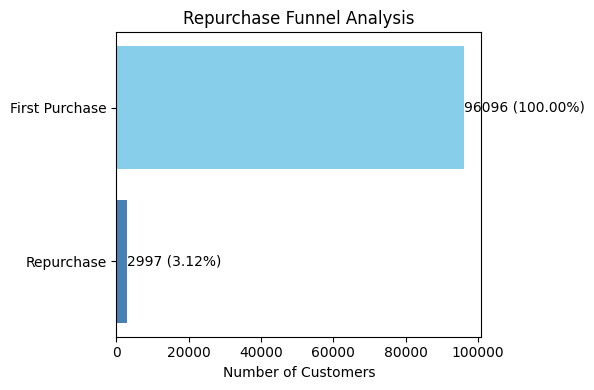

In [25]:
import matplotlib.pyplot as plt

# 漏斗階段與對應數值
stages = ['First Purchase', 'Repurchase']
values = [total_customers, repurchase_customers]

# 繪製水平長條圖
plt.figure(figsize=(6, 4))
bars = plt.barh(stages, values, color=['skyblue', 'steelblue'])

plt.xlabel('Number of Customers')
plt.title('Repurchase Funnel Analysis')

# 反轉 Y 軸，符合漏斗從上到下的視覺效果
plt.gca().invert_yaxis()

# 在長條上標註數值與百分比
for bar, value in zip(bars, values):
    percent = value / total_customers * 100
    plt.text(value, bar.get_y() + bar.get_height() / 2, 
             f'{value} ({percent:.2f}%)', 
             va='center', ha='left', fontsize=10)

plt.tight_layout()
plt.show()


In [26]:
import plotly.graph_objects as go

# 漏斗階段與數值
stages = ['First Purchase', 'Repurchase']
values = [total_customers, repurchase_customers]

# 繪製漏斗圖
fig = go.Figure(go.Funnel(
    y=stages,  # 漏斗階段
    x=values,  # 對應數值
    textinfo="value+percent initial",  # 顯示人數 + 初始百分比
    marker={"color": ["skyblue", "steelblue"]}  # 自訂顏色
))

fig.update_layout(
    title="Repurchase Funnel Analysis",
    width=600,
    height=400,
    font={"family": "Arial", "size": 14}
)

fig.show()



分析不同客群再購轉換率

- 依據州別 (customer_state) 分析

In [27]:
# 計算各州再購轉換率
state_summary = features.groupby('customer_state')['is_repurchase'].agg(['count', 'sum'])
state_summary['repurchase_rate'] = state_summary['sum'] / state_summary['count'] * 100
state_summary = state_summary.sort_values('repurchase_rate', ascending=False)

# 顯示前幾個州
print(state_summary[['repurchase_rate']].head())


                repurchase_rate
customer_state                 
AC                     9.876543
RO                     9.486166
RJ                     6.979458
MT                     6.835722
GO                     6.633663


In [28]:
# agg() 是一個函數，用來對分組後的資料進行多重聚合 # 計算每個州的客戶數、計算「有再購行為」的客戶數
# sort_values() 是一個函數，用來對資料進行排序
# ascending 是一個參數，用來指定排序的方式
# True 代表升冪排序，False 代表降冪排序 > 由大到小排序（遞減）

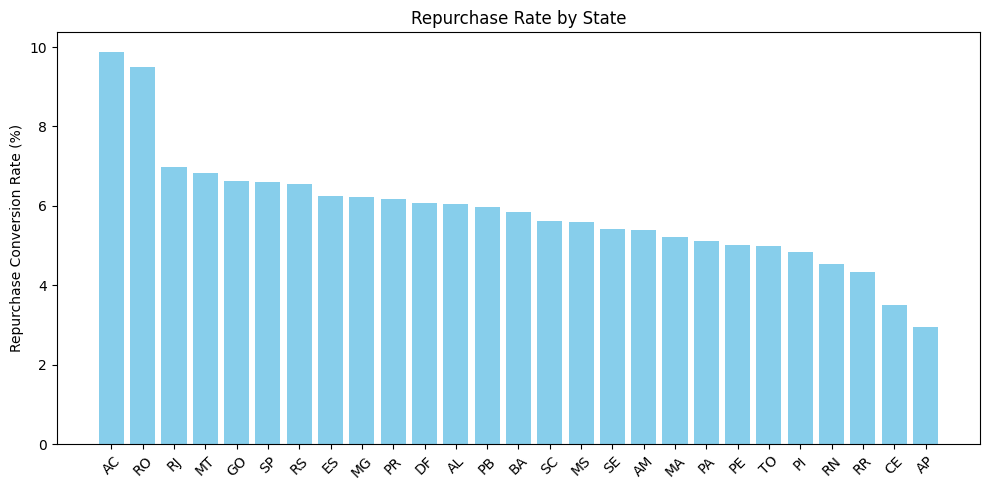

In [29]:
# 視覺化圖表

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(state_summary.index, state_summary['repurchase_rate'], color='skyblue')
plt.xticks(rotation=45)
plt.ylabel('Repurchase Conversion Rate (%)')
plt.title('Repurchase Rate by State')
plt.tight_layout()
plt.show()

- 依據付款方式分析

In [30]:
# 找出每位客戶主要的付款方式

# 付款方式欄位（根據前面 features 製作的資料表）
payment_columns = ['credit_card', 'boleto', 'voucher', 'debit_card']

# 尋找每位客戶最常用的付款方式
features['main_payment'] = features[payment_columns].idxmax(axis=1)

In [31]:
# idmax() 是一個函數，用來尋找每一行列中最大值的索引
# axis=1 代表沿著列的方向尋找最大值 
# axis=0 代表沿著行的方向尋找最大值

In [32]:
# 計算再購轉換率

payment_summary = features.groupby('main_payment')['is_repurchase'].agg(['count', 'sum'])
payment_summary['repurchase_rate'] = payment_summary['sum'] / payment_summary['count'] * 100
payment_summary = payment_summary.sort_values('repurchase_rate', ascending=False)

print(payment_summary[['repurchase_rate']])

              repurchase_rate
main_payment                 
voucher              9.378238
credit_card          6.669110
boleto               5.276024
debit_card           2.029770


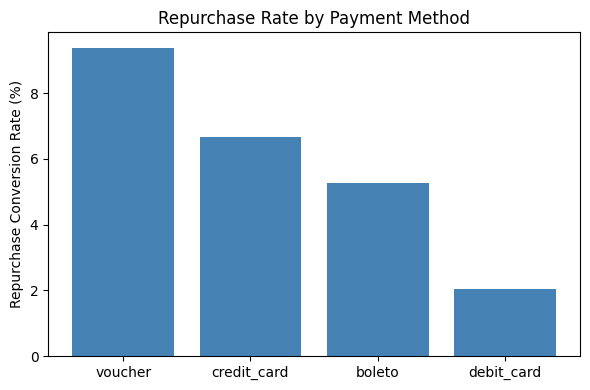

In [33]:
# 視覺化圖表

plt.figure(figsize=(6, 4))
plt.bar(payment_summary.index, payment_summary['repurchase_rate'], color='steelblue')
plt.ylabel('Repurchase Conversion Rate (%)')
plt.title('Repurchase Rate by Payment Method')
plt.tight_layout()
plt.show()

#### **4. 建立預測模型 (LightGBM)** 

處理分類變數

In [34]:
# !pip install lightgbm
# pip install --upgrade lightgbm

In [35]:
from sklearn.model_selection import train_test_split

# 根據再購率取前 10 州
state_summary = features.groupby('customer_state')['is_repurchase'].agg(['count', 'sum'])
state_summary['repurchase_rate'] = state_summary['sum'] / state_summary['count'] * 100
top_states_by_rate = state_summary.sort_values('repurchase_rate', ascending=False).head(10).index


# 將其餘州合併為 'Other'
features['customer_state_grouped'] = features['customer_state'].apply(
    lambda x: x if x in top_states_by_rate else 'Other'
)

# 刪除原始 customer_state 欄位
features.drop(columns=['customer_state'], inplace=True)

# 確保 One-Hot Encoding 只做一次
if 'customer_state_grouped' in features.columns and features['customer_state_grouped'].dtype == 'object':
    features = pd.get_dummies(features, columns=['customer_state_grouped'], drop_first=True)

# 解決 main_payment 的 object 型態

# 將 main_payment 缺失值處理成 'unknown'，避免 NaN 問題
features['main_payment'] = features['main_payment'].fillna('unknown')

# One-Hot Encoding main_payment 欄位
features = pd.get_dummies(features, columns=['main_payment'], drop_first=True)

# 處理付款方式次數統計欄位（變成 0/1 是否使用過）
payment_cols = ['credit_card', 'boleto', 'voucher', 'debit_card']

for col in payment_cols:
    if col in features.columns:
        features[col] = (features[col] > 0).astype(int)


In [36]:
# apply() 是一個函數，用來對資料進行逐行或逐列的操作
# lambda 是一個匿名函數，用來定義簡單的函數
# .dtype() 是一個屬性，用來檢查資料的型態
# drop_first=True 代表刪除第一個類別，避免虛擬變數陷阱
# 虛擬變數陷阱是指在進行迴歸分析時，當有多個類別變數時，會導致多重共線性問題

刪除無意義的識別欄位 

In [37]:
drop_cols = ['customer_unique_id', 'order_id', 'is_repurchase', 'order_count', 'recency_days'] 
X = features.drop(columns=drop_cols)
y = features['is_repurchase']

# 填補缺失值（以防萬一）
X = X.fillna(0)

In [38]:
# 為了避免資料洩漏，刪除'is_repurchase', 'order_counts', 'recency_days'。回購次數多月會回購、最近一次購買時間越長越不會回購
# 這是因為我們要預測的目標變數就是'is_repurchase'，如果在特徵中保留它，模型就會知道答案

切分訓練集 / 測試集

In [39]:
# 用 customer_unique_id 做分組切分
# 如果隨機切分資料集，同一位消費者行為可能同時出現在訓練集與測試集
# 會造成模型「偷看未來」的資訊洩漏（Data Leakage），導致測試結果過於樂觀
# 這樣的切分方式可以確保每位客戶只出現在訓練集或測試集中，避免資料洩漏的問題

from sklearn.model_selection import GroupShuffleSplit

groups = features['customer_unique_id']
gss = GroupShuffleSplit(test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [40]:
# GroupShuffleSplit 分組隨機切分器，可以根據某個「群組標籤」來切分資料集
# test_size=0.2 → 測試集佔 20%，訓練集佔 80%
# random_state=42 → 固定亂數種子，確保切分結果可重現
# gss.split() 根據 groups 來切分資料，不會直接產生切分結果，而是回傳一個 generator 物件。
# 這個 generator 可以產生「多組不同的切分索引」，每次呼叫都能產生新的切分（類似批次資料的概念）。
# next(gss.split(X, y, groups=groups)) 表示「只要第一組切分結果就好」，不需要產生多組資料切分方案
# 會從 generator 物件中，取出第一個產生的結果。（常見於單次實驗）
# .iloc 根據索引位置選取資料。位置索引（0, 1, 2）。.iloc[0] → 第一筆資料
# .loc index 標籤值。.loc[101] → 標籤是 101 的資料

# 可以多次執行模型訓練與評估（類似交叉驗證）
# for train_idx, test_idx in gss.split(X, y, groups=groups):

建立模型

In [41]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, classification_report

model = LGBMClassifier(
    objective='binary',
    learning_rate=0.05,
    num_leaves=15,             # 降低複雜度防止過擬合
    max_depth=5,               # 控制樹的最大深度
    n_estimators=1000,         # 提高疊代次數，搭配 early stopping 使用
    reg_alpha=0.1,             # L1 正則化，防止過擬合
    reg_lambda=0.1,            # L2 正則化，防止過擬合
    class_weight='balanced',   # 自動處理資料不平衡問題
    random_state=42
)

| 參數                        | 說明                                                   |
| ------------------------- | ---------------------------------------------------- |
| `objective='binary'`      | 指定這是「**二元分類問題**」，適用於 0/1 預測（如：再購 vs 未再購）。            |
| `learning_rate=0.05`      | 學習率，控制每次樹的調整幅度，數值越小學習越慢但泛化效果通常較好。                    |
| `num_leaves=15`           | 每棵樹的最大葉節點數，**減少模型複雜度**，防止過擬合。                        |
| `max_depth=5`             | 限制每棵樹的最大深度，防止模型學習過多細節（過擬合）。                          |
| `n_estimators=1000`       | 最多訓練 1000 棵樹，建議搭配 `early_stopping_rounds` 使用來避免浪費資源。 |
| `reg_alpha=0.1`           | **L1 正則化**（讓部分特徵權重變成 0，達到特徵選擇的效果），防止過擬合。             |
| `reg_lambda=0.1`          | **L2 正則化**（讓模型權重保持平滑），同樣用於防止過擬合。                     |
| `class_weight='balanced'` | 自動根據資料中正負類別的比例調整權重，解決資料不平衡問題（例如再購客戶較少）。              |
| `random_state=42`         | 固定隨機種子，確保實驗結果可重現。                                    |


模型訓練 + Early Stopping

In [42]:
from lightgbm import early_stopping, log_evaluation

callbacks = [early_stopping(stopping_rounds=50), log_evaluation(period=100)]

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)], # 設定驗證集，early stopping 和評估指標都會根據這組資料來判斷
    eval_metric='auc', # 評估指標選用 AUC
    callbacks = callbacks # 加入剛剛定義的回調函數
)

[LightGBM] [Info] Number of positive: 5085, number of negative: 74467
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 289
[LightGBM] [Info] Number of data points in the train set: 79552, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.625042	valid_0's binary_logloss: 0.621187
Early stopping, best iteration is:
[52]	valid_0's auc: 0.627105	valid_0's binary_logloss: 0.632772


LGBMClassifier(class_weight='balanced', learning_rate=0.05, max_depth=5,
               n_estimators=1000, num_leaves=15, objective='binary',
               random_state=42, reg_alpha=0.1, reg_lambda=0.1)

In [43]:
# early_stopping：當模型在驗證集上的表現停滯一段時間，自動停止訓練。
# log_evaluation：定期輸出模型訓練的評估指標，方便觀察訓練過程。
# early_stopping(stopping_rounds=50)：如果模型連續 50 次迭代沒有提升，就停止訓練（避免浪費計算資源）。
# log_evaluation(period=100)：每 100 次迭代輸出一次評估指標（例如 AUC 分數）。

檢查 object 型態 > LightGBM 只能處理數值型態的資料

In [44]:
print(features.dtypes[features.dtypes == 'object'])

customer_unique_id    object
order_id              object
dtype: object


檢查是否發生資料洩漏

- 特徵重要性 (Mutual Information Score) 

In [45]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(X, y)
mi_df = pd.DataFrame({'Feature': X.columns, 'MI_Score': mi_scores})
print(mi_df.sort_values('MI_Score', ascending=False))

                         Feature  MI_Score
0                   monetary_avg  0.065229
2                    credit_card  0.019105
16      main_payment_credit_card  0.018604
15     customer_state_grouped_SP  0.011113
1                         boleto  0.002372
5                        voucher  0.002106
8      customer_state_grouped_MG  0.001875
10  customer_state_grouped_Other  0.001850
14     customer_state_grouped_RS  0.001111
12     customer_state_grouped_RJ  0.000932
13     customer_state_grouped_RO  0.000756
7      customer_state_grouped_GO  0.000531
3                     debit_card  0.000132
17       main_payment_debit_card  0.000000
9      customer_state_grouped_MT  0.000000
11     customer_state_grouped_PR  0.000000
6      customer_state_grouped_ES  0.000000
4                    not_defined  0.000000
18          main_payment_voucher  0.000000


- 目標變數分布是否合理

In [46]:
print(y.value_counts(normalize=True))

is_repurchase
0    0.936223
1    0.063777
Name: proportion, dtype: float64


- 信用卡使用次數透露是否回購 > 改成 "是否用過" 這個特徵

In [47]:
print(features.groupby('is_repurchase')['credit_card'].mean())

is_repurchase
0    0.769428
1    0.821507
Name: credit_card, dtype: float64


預測結果

In [48]:
y_pred_prob = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_prob >= 0.5).astype(int)

print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_prob):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

AUC-ROC: 0.6271
F1 Score: 0.1492
Precision: 0.0857
Recall: 0.5752

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.59      0.73     18632
           1       0.09      0.58      0.15      1257

    accuracy                           0.59     19889
   macro avg       0.52      0.58      0.44     19889
weighted avg       0.90      0.59      0.69     19889



特徵重要性分析

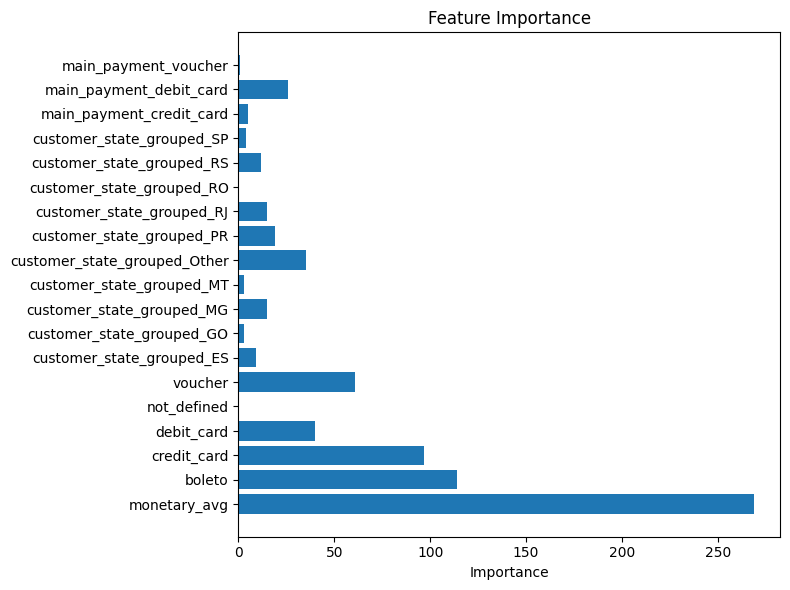

In [49]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(8, 6))
plt.barh(feature_names, importances)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

高再購潛力客戶名單

In [50]:
features['repurchase_prob'] = model.predict_proba(X)[:, 1]
high_potential_customers = features[features['repurchase_prob'] >= 0.7][
    ['customer_unique_id', 'repurchase_prob']
].sort_values(by='repurchase_prob', ascending=False)

print("📌 Top 10 High Repurchase Probability Customers:")
print(high_potential_customers.head(10))

# 可以直接存檔
# high_potential_customers.to_csv('high_potential_customers.csv', index=False)
high_potential_customers.head()

📌 Top 10 High Repurchase Probability Customers:
                     customer_unique_id  repurchase_prob
9751   18e3d276253780b44b5b7bf83f6785ec         0.963456
66352  aa89a987e1e092c318fbdc4b0e3dcc44         0.963456
66353  aa89a987e1e092c318fbdc4b0e3dcc44         0.963456
9750   18e3d276253780b44b5b7bf83f6785ec         0.963456
9749   18e3d276253780b44b5b7bf83f6785ec         0.963456
22370  397b44d5bb99eabf54ea9c2b41ebb905         0.960756
22371  397b44d5bb99eabf54ea9c2b41ebb905         0.960756
22373  397b44d5bb99eabf54ea9c2b41ebb905         0.960756
22372  397b44d5bb99eabf54ea9c2b41ebb905         0.960756
91262  eaa604ab9f816252edb7a8d297f932e5         0.960236


,customer_unique_id,repurchase_prob
9751,18e3d276253780b44b5b7bf83f6785ec,0.963456
66352,aa89a987e1e092c318fbdc4b0e3dcc44,0.963456
66353,aa89a987e1e092c318fbdc4b0e3dcc44,0.963456
9750,18e3d276253780b44b5b7bf83f6785ec,0.963456
9749,18e3d276253780b44b5b7bf83f6785ec,0.963456


#### **5. 客戶分群分析 (Audience Segmentation)** 

準備分群特徵

- RFM 模型

| 特徵        | 說明         |
| --------- | ---------- |
| Recency   | 最近一次購買距今幾天 |
| Frequency | 購買次數       |
| Monetary  | 平均消費金額     |


In [52]:
high_potential_customers = pd.merge(
    high_potential_customers,  # 左表：只包含高潛力客戶的 ID 和預測機率
    features[['customer_unique_id', 'recency_days', 'order_count', 'monetary_avg']],  # 右表：完整特徵
    on='customer_unique_id',
    how='left'
)

segmentation_features = high_potential_customers[['recency_days', 'order_count', 'monetary_avg', 'repurchase_prob']]

# 確保沒有缺失值
segmentation_features.fillna(0, inplace=True)

C:\Users\Maggie\AppData\Local\Temp\ipykernel_8396\1470436482.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



特徵標準化（Standardization）

K-Means 對數值範圍很敏感

In [53]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
segmentation_scaled = scaler.fit_transform(segmentation_features)

使用 K-Means 分群

- 決定最佳群數（Elbow Method）

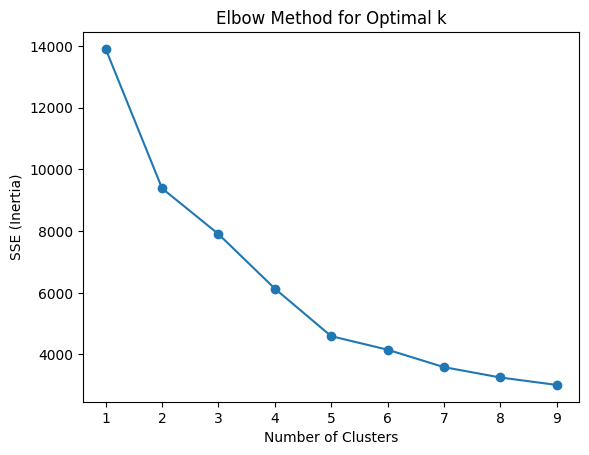

In [56]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

sse = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(segmentation_scaled)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 10), sse, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.show()

- 正式分群

In [79]:
kmeans = KMeans(n_clusters=2, random_state=42)
high_potential_customers['customer_segment'] = kmeans.fit_predict(segmentation_scaled)

分析分群結果

In [80]:
segment_analysis = high_potential_customers.groupby('customer_segment')[['recency_days', 'order_count', 'monetary_avg', 'repurchase_prob']].mean()
print(segment_analysis)

                  recency_days  order_count  monetary_avg  repurchase_prob
customer_segment                                                          
0                   210.452967     2.921852    158.610137         0.886698
1                   284.931742     1.441050    114.484451         0.716045


- 客群規模占比

In [81]:
group_distribution = high_potential_customers['customer_segment'].value_counts(normalize=True) * 100
print(group_distribution)

customer_segment
1    60.253092
0    39.746908
Name: proportion, dtype: float64


合併表格

In [82]:
# 將 group_distribution 轉成 DataFrame 並重設欄位名稱
group_distribution_df = group_distribution.rename('percentage (%)').reset_index()
group_distribution_df.columns = ['customer_segment', 'percentage (%)']

# segment_analysis 原本的 index 是 customer_segment，先重設 index
segment_analysis = segment_analysis.reset_index()

# 合併兩個 DataFrame
merged_df = pd.merge(segment_analysis, group_distribution_df, on='customer_segment')

# 按群組排序（如果需要）
merged_df = merged_df.sort_values('customer_segment').reset_index(drop=True)

# 顯示結果
print(merged_df.to_string(index=False))

 customer_segment  recency_days  order_count  monetary_avg  repurchase_prob  percentage (%)
                0    210.452967     2.921852    158.610137         0.886698       39.746908
                1    284.931742     1.441050    114.484451         0.716045       60.253092


延伸 k = 5

In [83]:
kmeans = KMeans(n_clusters=5, random_state=42)
high_potential_customers['customer_segment'] = kmeans.fit_predict(segmentation_scaled)

segment_analysis = high_potential_customers.groupby('customer_segment')[['recency_days', 'order_count', 'monetary_avg', 'repurchase_prob']].mean()

group_distribution = high_potential_customers['customer_segment'].value_counts(normalize=True) * 100

group_distribution_df = group_distribution.rename('percentage (%)').reset_index()
group_distribution_df.columns = ['customer_segment', 'percentage (%)']

segment_analysis = segment_analysis.reset_index()

merged_df = pd.merge(segment_analysis, group_distribution_df, on='customer_segment')

merged_df = merged_df.sort_values('customer_segment').reset_index(drop=True)

print(merged_df.to_string(index=False))

 customer_segment  recency_days  order_count  monetary_avg  repurchase_prob  percentage (%)
                0    205.679208     2.358416    127.833960         0.891745       29.048030
                1    165.343980     1.576577    116.662441         0.716348       35.116480
                2    186.750000     6.260870    170.331250         0.903146        5.291918
                3    438.265222     1.429309    110.989200         0.724843       27.868852
                4    205.548387     2.290323    522.553871         0.878017        2.674720


> 行銷策略

k = 2

| 群組 | Recency（天） | Frequency | Monetary | 客戶特徵       | 占比 (%) | 預期行銷貢獻 | 行銷優先級 | 行銷策略建議        |
| -- | ---------- | --------- | -------- | ---------- | ------ | ------ | ----- | ------------- |
| 0  | 210.45     | 2.92      | 158.61   | 穩定回購、高再購機率 | 39.75  | 高      | 高     | 強化專屬優惠，提高客單價  |
| 1  | 284.93     | 1.44      | 114.48   | 回購頻率低、價值偏低 | 60.25  | 中低     | 中     | 提供入門優惠，觀察轉化效果 |


k = 5

| 群組 | Recency（天） | Frequency | Monetary   | 客戶特徵       | 占比 (%) | 預期行銷貢獻 | 行銷優先級 | 行銷策略建議               |
| -- | ---------- | --------- | ---------- | ---------- | ------ | ------ | ----- | -------------------- |
| 0  | 205.68     | 2.36      | 127.83     | 穩定回購客戶     | 29.05  | 高      | 高     | 提供專屬優惠，提高客單價         |
| 1  | **165.34** | 1.58      | 116.66     | 最近活躍、新興客戶  | 35.12  | 中      | 中     | 提供首次回購優惠，提升忠誠度       |
| 2  | 186.75     | **6.26**  | 170.33     | 超高回購忠誠客戶   | 5.29   | 極高     | 最高    | 重點維護 VIP，強化關係        |
| 3  | **438.27** | 1.43      | 110.99     | 長期未回購、流失客戶 | 27.87  | 低      | 低     | 一次性折扣測試回購意願，無回應即放棄   |
| 4  | 205.55     | 2.29      | **522.55** | 高單價潛力客戶    | 2.67   | 高      | 高     | 提供高價產品專屬優惠，打造 VIP 體驗 |
